In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, mean_absolute_error, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression
import category_encoders as ce
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import RidgeClassifier
import seaborn as sns

%matplotlib inline

C:\Users\yeboa\AppData\Local\Temp\ipykernel_16256\3030717524.py:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [2]:
# read data
df = pd.read_csv('../data_files/train_data.csv')
df2 = pd.read_csv('../data_files/test_data.csv')

In [3]:
ids = df2['Customer Id']

In [4]:
df.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


### Preprocessing Steps

- Number of windows encoded into ['less than 5', 'greater than 5', '>10']
- Insurance period not scaled

In [5]:
def replace_values(val):
    if val == '>=10':
        return 'greater than 10'
    elif val == '   .':
        return 'no data'
    elif int(val) < 5:
        return 'less than 5'
    else:
        return 'greater than 5'

### Impute NaN's & Preprocess Data

In [6]:
def preprocess(df, filename):
    # drop ID col 
    df = df.drop('Customer Id', axis=1)
   
    # encode number of windows
    df['NumberOfWindows'] = df['NumberOfWindows'].apply(replace_values)
    
    
    # impute garden based on settlement
    df.loc[df.Settlement == 'U', 'Garden'] = 'V'
    df.loc[df.Settlement != 'U', 'Garden'] = 'O'
    
    
    # impute building dimension
    rural_dim = df[df['Settlement'] == 'R']
    rural_dim_mean = rural_dim["Building Dimension"].mean()
    urban_dim = df[df['Settlement'] == 'U']
    urban_dim_mean = urban_dim["Building Dimension"].mean()
    for i in range(len(df.Settlement)):
        if (df.Settlement[i] == 'U') and pd.isnull(df['Building Dimension'][i]):
            df.at[i, 'Building Dimension'] = urban_dim_mean
        elif (df.Settlement[i] == 'R') and pd.isnull(df['Building Dimension'][i]):
            df.at[i, 'Building Dimension'] = rural_dim_mean
        
        
    #replace occupancy NaN values with mode date
    date_mode = df.Date_of_Occupancy.mode()[0]
    df.Date_of_Occupancy.fillna(date_mode, inplace=True)
    df['Date_of_Occupancy'] = df['Date_of_Occupancy'].astype(int)
    
    
    # Convert the numerical values to string labels for building type
    mapping = {1: 'type1', 2: 'type2', 3: 'type3', 4: 'type4'}
    df['Building_Type'] = df['Building_Type'].map(mapping)
    
    # drop geo code
    df = df.drop('Geo_Code', axis=1)
    
    # create occupancy period 
    df['Occupancy_Period'] = df['YearOfObservation'] - df['Date_of_Occupancy']
    df = df.drop(columns=['YearOfObservation', 'Date_of_Occupancy'], axis=1)
    
    # save df
    df.to_csv(filename, index=False)

In [7]:
# save and reload processed data
preprocess(df, '../data_files/train_clean2.csv')
preprocess(df2, '../data_files/test_clean2.csv')
df = pd.read_csv('../data_files/train_clean2.csv')
df2 = pd.read_csv('../data_files/test_clean2.csv')

In [8]:
df.head()

,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Claim,Occupancy_Period
0,1.0,0,N,V,V,U,290.0,type1,no data,0,53
1,1.0,0,V,N,O,R,490.0,type1,less than 5,0,165
2,1.0,0,N,V,V,U,595.0,type1,no data,0,54
3,1.0,0,V,V,V,U,2840.0,type1,no data,0,53
4,1.0,0,V,N,O,R,680.0,type1,less than 5,0,214


In [9]:
df2.head()

,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Occupancy_Period
0,1.000000,0,V,N,O,R,300.0,type1,less than 5,53
1,0.997268,0,V,N,O,R,300.0,type1,less than 5,56
2,0.369863,0,V,V,V,U,790.0,type1,no data,53
3,1.000000,0,V,N,O,R,1405.0,type1,less than 5,10
4,1.000000,0,V,N,O,R,1405.0,type1,less than 5,12


### Train Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Claim', axis=1), df['Claim'], test_size=0.2, random_state=42)  
X_train

,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Occupancy_Period
5266,0.997268,1,N,V,V,U,850.000000,type4,no data,56
5441,1.000000,0,N,V,V,U,2135.000000,type2,no data,55
7025,1.000000,0,V,N,O,R,2700.000000,type3,greater than 5,43
7130,1.000000,1,V,V,V,U,1575.211611,type1,no data,314
4454,1.000000,0,V,N,O,R,1080.000000,type2,greater than 5,53
...,...,...,...,...,...,...,...,...,...,...
3772,1.000000,0,V,N,O,R,750.000000,type2,greater than 5,25
5191,1.000000,1,V,N,O,R,2670.000000,type4,greater than 5,63
5226,1.000000,1,V,N,O,R,2200.000000,type4,greater than 5,110
5390,1.000000,1,N,V,V,U,634.000000,type2,no data,52


### Encode Categorical Cols and Scale Data

In [11]:
cols_to_encode = ['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement', 'Building_Type', 'NumberOfWindows']

# Create a OneHotEncoder object
ohe = OneHotEncoder(sparse=False, drop='first')

# Fit the encoder on the train data and transform both the train and test data
X_train_encoded = ohe.fit_transform(X_train[cols_to_encode])
X_test_encoded = ohe.transform(X_test[cols_to_encode])
df2_encoded = ohe.transform(df2[cols_to_encode])

# Create new column names for the one-hot encoded columns
new_col_names = ohe.get_feature_names(cols_to_encode)

# Replace the original columns with the one-hot encoded columns
X_train[new_col_names] = X_train_encoded
X_test[new_col_names] = X_test_encoded
df2[new_col_names] = df2_encoded

# Drop the original columns
X_train.drop(columns=cols_to_encode, inplace=True)
X_test.drop(columns=cols_to_encode, inplace=True)
df2.drop(columns=cols_to_encode, inplace=True)

C:\Users\yeboa\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [12]:
# instantiate the scaler
scaler = StandardScaler()

# define columns to scale
cols_to_scale = ['Building Dimension', 'Occupancy_Period']

# fit and transform the training set
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

# transform the test set using the fitted scaler from the training set
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
df2[cols_to_scale] = scaler.transform(df2[cols_to_scale])

X_train

,Insured_Period,Residential,Building Dimension,Occupancy_Period,Building_Painted_V,Building_Fenced_V,Garden_V,Settlement_U,Building_Type_type2,Building_Type_type3,Building_Type_type4,NumberOfWindows_greater than 5,NumberOfWindows_less than 5,NumberOfWindows_no data
5266,0.997268,1,-0.452685,0.182678,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
5441,1.000000,0,0.115754,0.154069,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
7025,1.000000,0,0.365690,-0.189241,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7130,1.000000,1,-0.131877,7.563840,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4454,1.000000,0,-0.350941,0.096851,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,1.000000,0,-0.496922,-0.704206,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5191,1.000000,1,0.352419,0.382942,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5226,1.000000,1,0.144508,1.727572,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5390,1.000000,1,-0.548236,0.068241,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


### Model Building

In [13]:
def analyze_results(final_model, X_test, y_pred):
    # Predict the probabilities of the test set
    y_prob = final_model.predict_proba(X_test)[:, 1]

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.colorbar()
    
    # Add the number of values in each cell of the confusion matrix
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment='center',
                     verticalalignment='center')
            
    plt.title('Confusion matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.yticks([0, 1], ['Negative', 'Positive'])
    plt.show()

    # Compute the ROC curve and ROC AUC score
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Compute the ROC curve and ROC AUC score
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # plot ROC curve
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate (1-specificity)')
    plt.ylabel('True Positive Rate (sensitivity)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')

    # identify optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    print("Optimal threshold:", optimal_threshold)

In [14]:
def train_random_forest_model(X_train, y_train, X_test, output_file, df_test, threshold=0.5):
    # Define the parameter grid to search over
    param_grid = {'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 10, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['sqrt', 'log2', None]}

    # Create a RandomForestClassifier
    rfc = RandomForestClassifier(random_state=42)

    # Create a GridSearchCV object
    grid_search = GridSearchCV(
        estimator=rfc, 
        param_grid=param_grid, 
        cv=5, 
        n_jobs=-1, 
        verbose=1, 
        scoring='roc_auc')

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters and the corresponding score
    print("Best parameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)

    # Use the best hyperparameters to create a final model
    final_model = RandomForestClassifier(**grid_search.best_params_, random_state=42)

    # Fit the final model to the data
    final_model.fit(X_train, y_train)

    # Predict the probabilities of the positive class for the test set
    y_pred_proba = final_model.predict_proba(X_test)[:, 1]

    # Apply the new decision threshold to classify the samples into positive or negative classes
    y_pred = np.where(y_pred_proba >= threshold, 1, 0)

    submission_pred_proba = final_model.predict_proba(df_test)[:, 1]
    submission_pred = np.where(submission_pred_proba >= threshold, 1, 0)
    results = pd.DataFrame(list(zip(ids, submission_pred)), columns=['Customer Id', 'Claim'])
    results.to_csv(output_file, index=False)

    # Print the classification report
    print(classification_report(y_test, y_pred))
    
    # Print the roc_score report   
    print(f'ROC_AUC_SCORE: {roc_auc_score(y_test, y_pred)}')
    
    analyze_results(final_model, X_test, y_pred)

In [22]:
def train_xgboost_model(X_train, y_train, X_test, output_file, df_test, threshold=0.5):
    # Define the XGBoost model
    xgb_model = XGBClassifier()

    # Define the parameter grid to search over
    params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.5]
    }

    # Define the grid search object
    grid_search = GridSearchCV(
        estimator=xgb_model, 
        param_grid=params, 
        scoring='roc_auc', 
        cv=5, 
#         refit='roc_auc', 
        n_jobs=-1
    )

    # Fit the grid search object to the data
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Train an XGBoost model with the best parameters
    xgb_model_best = XGBClassifier(**best_params)
    xgb_model_best.fit(X_train, y_train)

    # Predict the test set
    y_pred_prob = xgb_model_best.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    submission_pred_prob = xgb_model_best.predict_proba(df_test)[:, 1] 
    submission_pred = (submission_pred_prob >= threshold).astype(int)
    results = pd.DataFrame(list(zip(ids, submission_pred)), columns=['Customer Id', 'Claim'])
    results.to_csv(output_file, index=False)
    
    # Print the best parameters and best score
    print('Best parameters: ', best_params)
    print('Best score: ', best_score)
    
    # Print the classification report
    print(classification_report(y_test, y_pred))

    # Print the roc_score report   
    print(f'ROC_AUC_SCORE: {roc_auc_score(y_test, y_pred)}')
    
    analyze_results(xgb_model_best, X_test, y_pred)

In [16]:
def train_gradient_boosting_model(X_train, y_train, X_test, output_file, df_test, threshold=0.5):
    # Define the parameter grid to search over
    param_grid = {'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 10, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['sqrt', 'log2', None]}

    # Create a GradientBoostingClassifier
    gbc = GradientBoostingClassifier(random_state=42)

    # Create a GridSearchCV object
    grid_search = GridSearchCV(
        estimator=gbc, 
        param_grid=param_grid, 
        cv=5, 
        n_jobs=-1, 
        verbose=1, 
        scoring='roc_auc')

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters and the corresponding score
    print("Best parameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)

    # Use the best hyperparameters to create a final model
    final_model = GradientBoostingClassifier(**grid_search.best_params_, random_state=42)

    # Fit the final model to the data
    final_model.fit(X_train, y_train)

    # Predict the probabilities of the positive class for the test set
    y_prob = final_model.predict_proba(X_test)[:, 1]

    # Set a new threshold for classifying the samples
    y_pred = (y_prob >= threshold).astype(int)

    # Predict the labels of the submission set
    submission_prob = final_model.predict_proba(df_test)[:, 1] 
    submission_pred = (submission_prob >= threshold).astype(int)
    results = pd.DataFrame(list(zip(ids, submission_pred)), columns=['Customer Id', 'Claim'])
    results.to_csv(output_file, index=False)

    # Print the classification report
    print(classification_report(y_test, y_pred))
    
    # Print the roc_score report    
    print(f'ROC_AUC_SCORE: {roc_auc_score(y_test, y_pred)}')
    
    analyze_results(final_model, X_test, y_pred)

In [17]:
def train_stacking_model(X_train, y_train, X_test, output_file, df_test, threshold=0.5):
    # Define the base models
    base_models = [
        ('rf', RandomForestClassifier(random_state=42)),
        ('xgb', XGBClassifier(random_state=42)),
        ('gbc', GradientBoostingClassifier(random_state=42))
    ]

    # Define the meta model
    meta_model = LogisticRegression(random_state=42)

    # Fit the stacked model with the best number of estimators
    stacked_model = StackingClassifier(estimators=base_models, 
                                       final_estimator=meta_model)
    stacked_model.fit(X_train, y_train)

    # Make predictions on the test set and evaluate the model
    y_prob = stacked_model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob > threshold).astype(int)
    
    submission_prob = stacked_model.predict_proba(df_test)[:, 1] 
    submission_pred = (submission_prob > threshold).astype(int)
    results = pd.DataFrame(list(zip(ids, submission_pred)), columns=['Customer Id', 'Claim'])
    results.to_csv(output_file, index=False)
    
    print(classification_report(y_test, y_pred))

    # Print the roc_score report    
    print(f'ROC_AUC_SCORE: {roc_auc_score(y_test, y_pred)}')
    
    analyze_results(stacked_model, X_test, y_pred)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best score:  0.7122209207303136
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      1098
           1       0.60      0.17      0.27       334

    accuracy                           0.78      1432
   macro avg       0.70      0.57      0.57      1432
weighted avg       0.75      0.78      0.73      1432

ROC_AUC_SCORE: 0.5680251518820283


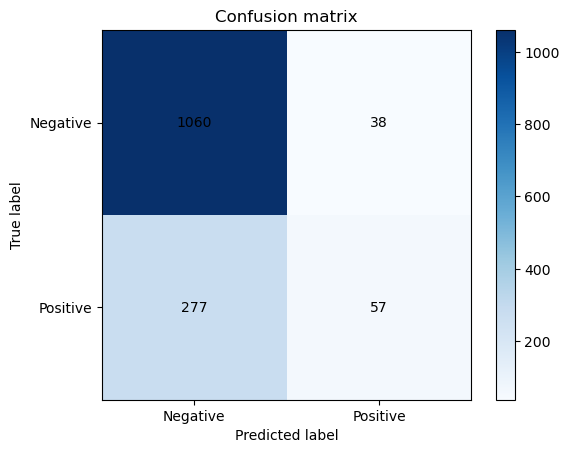

Optimal threshold: 0.22512623079613825


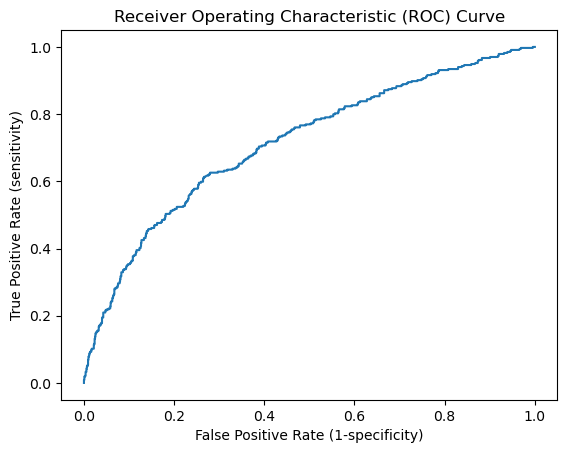

In [181]:
train_random_forest_model(X_train, y_train, X_test, '../submissions/random_forest.csv', df2)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best score:  0.7174250899844312
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      1098
           1       0.61      0.17      0.27       334

    accuracy                           0.78      1432
   macro avg       0.70      0.57      0.57      1432
weighted avg       0.75      0.78      0.73      1432

ROC_AUC_SCORE: 0.7119940446974904


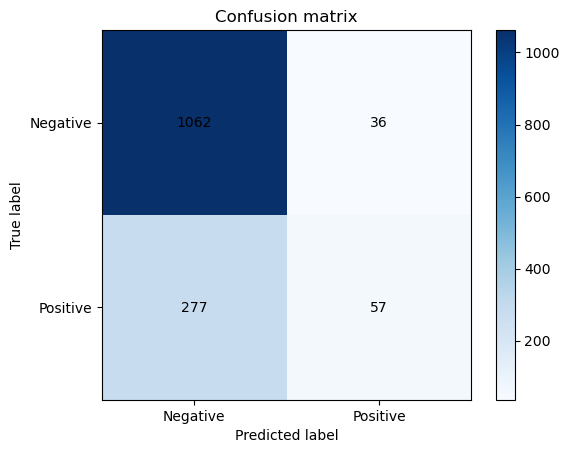

Optimal threshold: 0.22281797


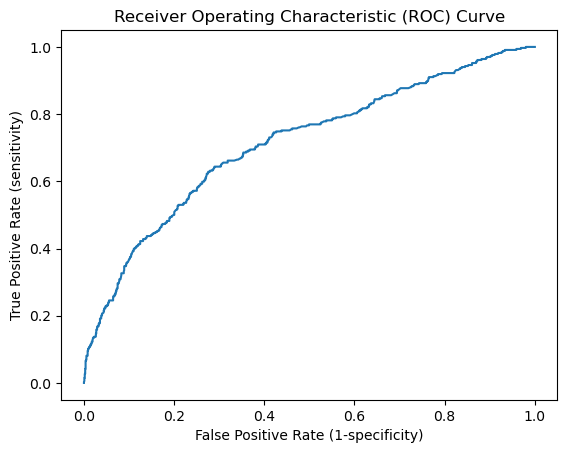

In [182]:
train_xgboost_model(X_train, y_train, X_test, '../submissions/xgboost.csv', df2)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best score:  0.7182690993120079
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      1098
           1       0.61      0.18      0.28       334

    accuracy                           0.78      1432
   macro avg       0.70      0.57      0.57      1432
weighted avg       0.75      0.78      0.73      1432

ROC_AUC_SCORE: 0.5725161698461002


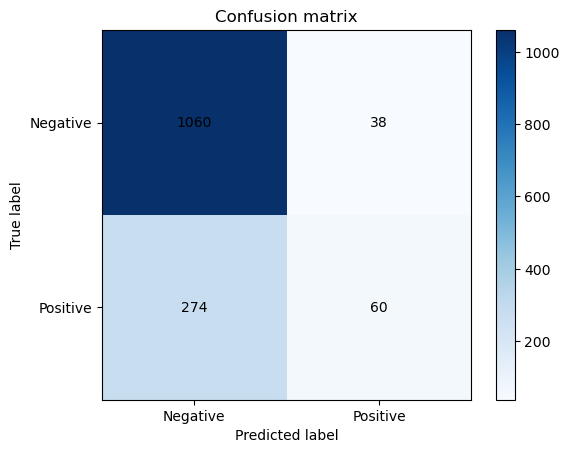

Optimal threshold: 0.22150334947703132


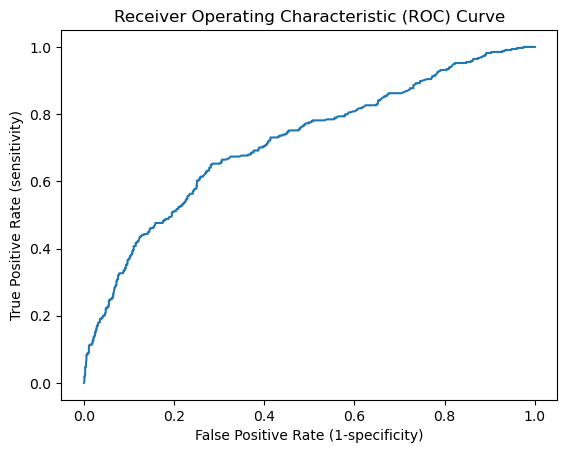

In [183]:
train_gradient_boosting_model(X_train, y_train, X_test, '../submissions/gradient_boosting.csv', df2)

              precision    recall  f1-score   support

           0       0.79      0.96      0.87      1098
           1       0.57      0.17      0.26       334

    accuracy                           0.78      1432
   macro avg       0.68      0.56      0.56      1432
weighted avg       0.74      0.78      0.73      1432

ROC_AUC_SCORE: 0.564706652269232


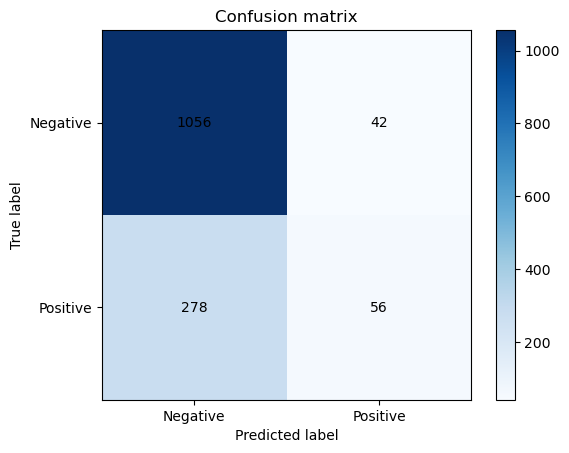

Optimal threshold: 0.18999266646518465


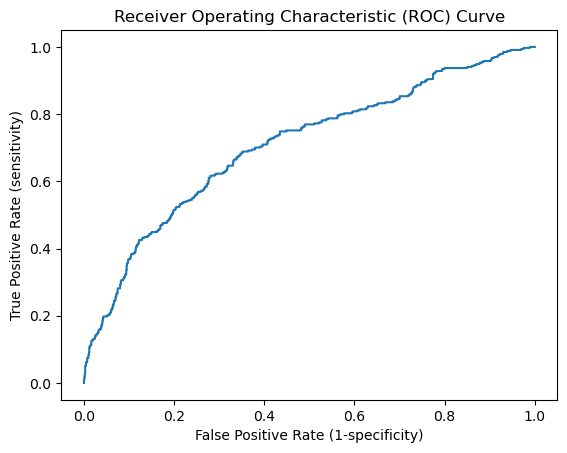

In [184]:
train_stacking_model(X_train, y_train, X_test, '../submissions/gradient_boosting.csv', df2)

### Fixing Data Imbalance

In [18]:
# Instantiate SMOTE
sm = SMOTE(random_state=42)

# Fit and transform the data
X_train_sm_resampled, y_train_sm_resampled = sm.fit_resample(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best score:  0.867617167605561
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1098
           1       0.41      0.40      0.41       334

    accuracy                           0.72      1432
   macro avg       0.61      0.61      0.61      1432
weighted avg       0.72      0.72      0.72      1432

ROC_AUC_SCORE: 0.6132979941755834


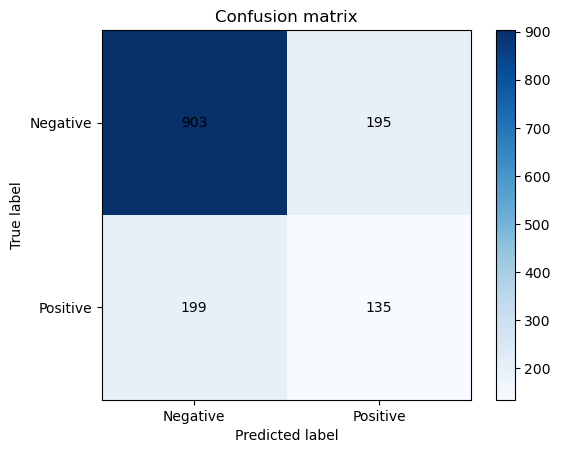

Optimal threshold: 0.32817658730158733


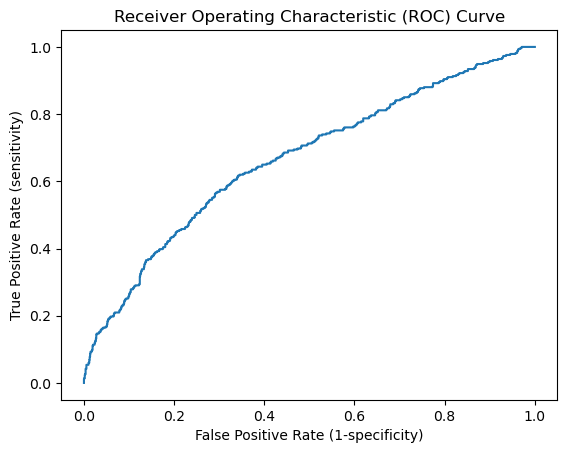

In [186]:
train_random_forest_model(X_train_sm_resampled, y_train_sm_resampled, X_test, '../submissions/smote_random_forest.csv', df2)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Best score:  0.8819717414516027
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1098
           1       0.45      0.36      0.40       334

    accuracy                           0.75      1432
   macro avg       0.63      0.61      0.62      1432
weighted avg       0.73      0.75      0.74      1432

ROC_AUC_SCORE: 0.6723888288995779


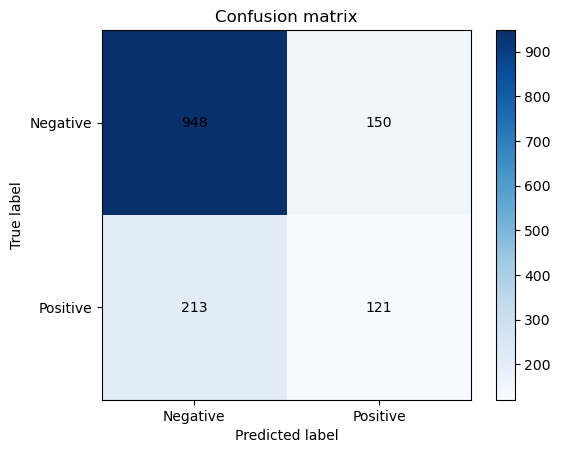

Optimal threshold: 0.39206344


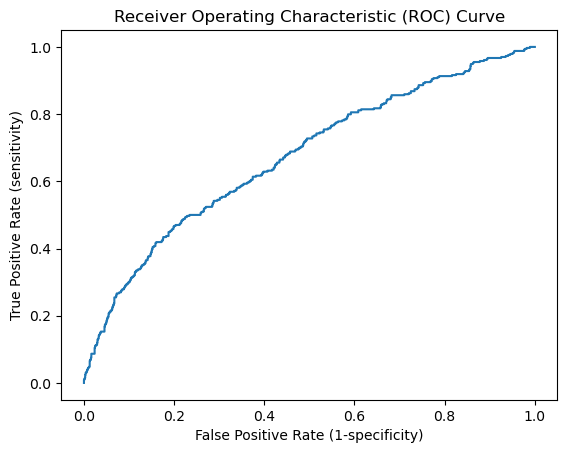

In [187]:
train_xgboost_model(X_train_sm_resampled, y_train_sm_resampled, X_test, '../submissions/smote_xgboost.csv', df2)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best score:  0.8846362280215153
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1098
           1       0.43      0.40      0.41       334

    accuracy                           0.74      1432
   macro avg       0.62      0.62      0.62      1432
weighted avg       0.73      0.74      0.73      1432

ROC_AUC_SCORE: 0.6180453301048177


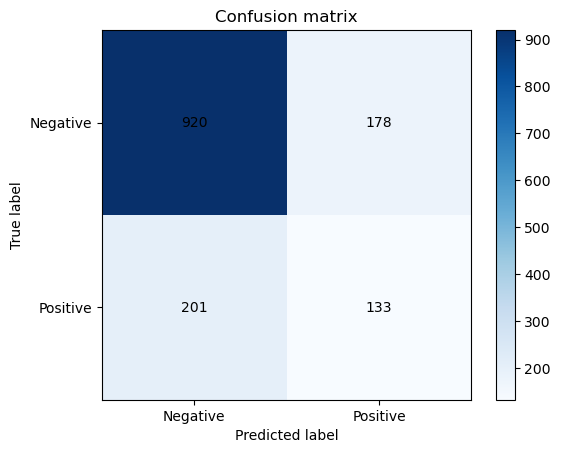

Optimal threshold: 0.4683468615369834


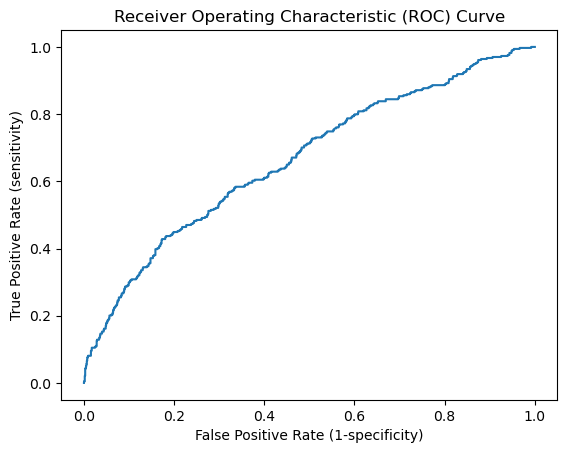

In [188]:
train_gradient_boosting_model(X_train_sm_resampled, y_train_sm_resampled, X_test, '../submissions/smote_gradient_boost.csv', df2)

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1098
           1       0.42      0.39      0.40       334

    accuracy                           0.73      1432
   macro avg       0.62      0.61      0.62      1432
weighted avg       0.73      0.73      0.73      1432

ROC_AUC_SCORE: 0.6120573061527218


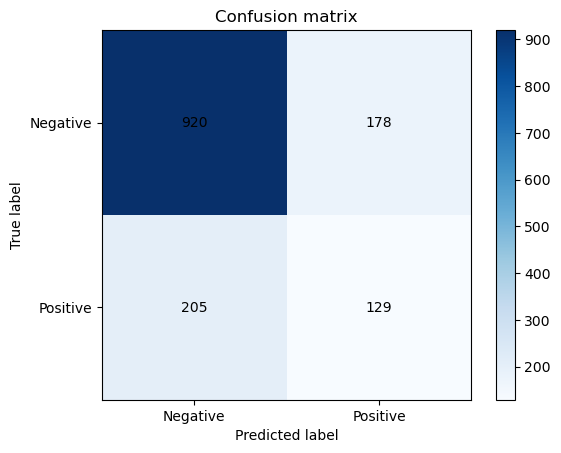

Optimal threshold: 0.3295078617037176


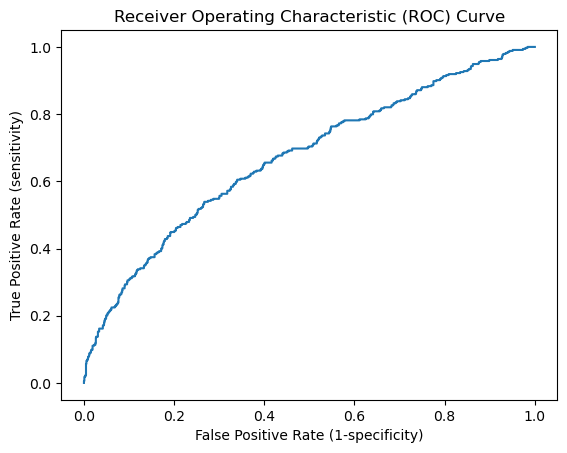

In [189]:
train_stacking_model(X_train_sm_resampled, y_train_sm_resampled, X_test, '../submissions/smote_stacking_model.csv', df2)

## Changing Decision Treshhold 

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best score:  0.7122209207303136
              precision    recall  f1-score   support

           0       0.86      0.73      0.79      1098
           1       0.41      0.61      0.49       334

    accuracy                           0.71      1432
   macro avg       0.64      0.67      0.64      1432
weighted avg       0.76      0.71      0.72      1432

ROC_AUC_SCORE: 0.6734618195303382


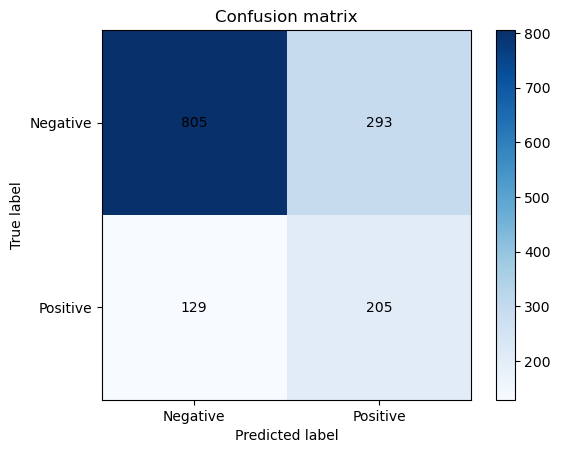

Optimal threshold: 0.22512623079613825


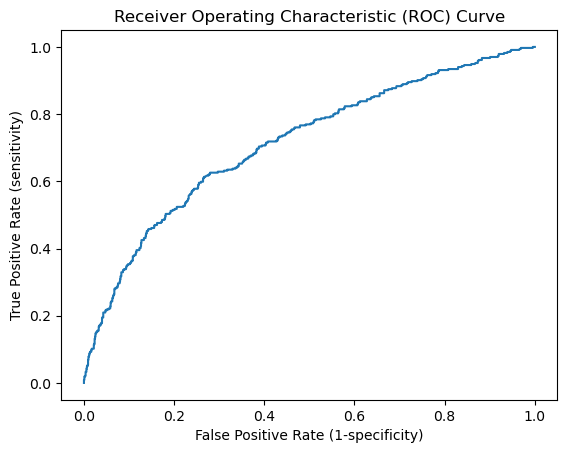

In [190]:
train_random_forest_model(X_train, y_train, X_test, '../submissions/th_random_forest.csv', df2, threshold=0.225)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best score:  0.7174250899844312
              precision    recall  f1-score   support

           0       0.87      0.71      0.78      1098
           1       0.40      0.64      0.49       334

    accuracy                           0.69      1432
   macro avg       0.63      0.68      0.64      1432
weighted avg       0.76      0.69      0.71      1432

ROC_AUC_SCORE: 0.6760059116739199


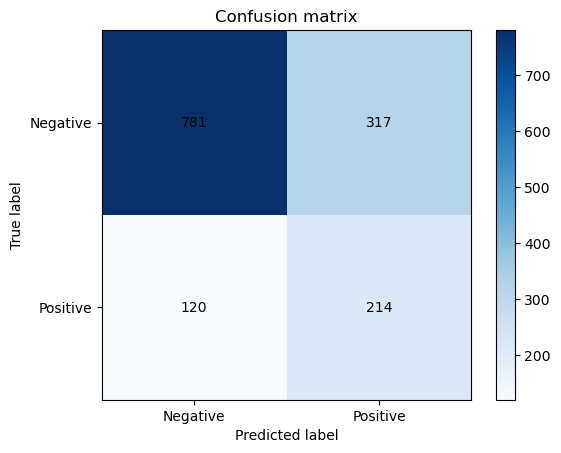

Optimal threshold: 0.22281797


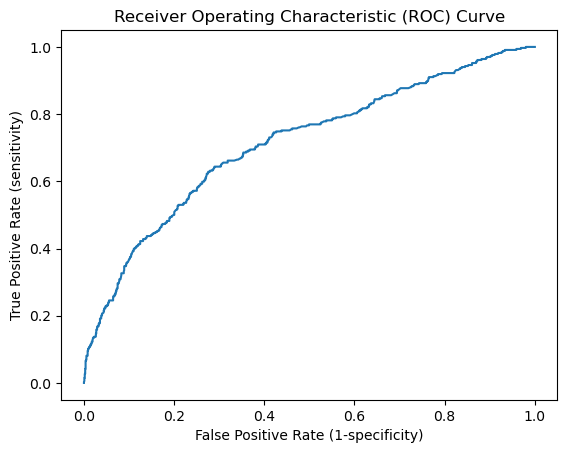

In [23]:
train_xgboost_model(X_train, y_train, X_test, '../submissions/th_xgboost.csv', df2, threshold=0.223)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best score:  0.7182690993120079
              precision    recall  f1-score   support

           0       0.87      0.72      0.79      1098
           1       0.41      0.64      0.50       334

    accuracy                           0.70      1432
   macro avg       0.64      0.68      0.64      1432
weighted avg       0.76      0.70      0.72      1432

ROC_AUC_SCORE: 0.6796488989234646


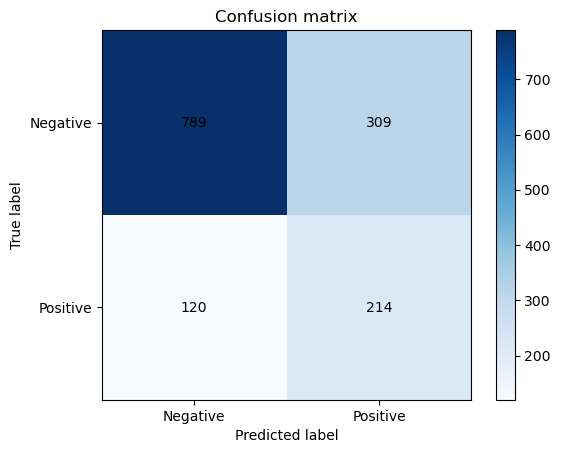

Optimal threshold: 0.22150334947703132


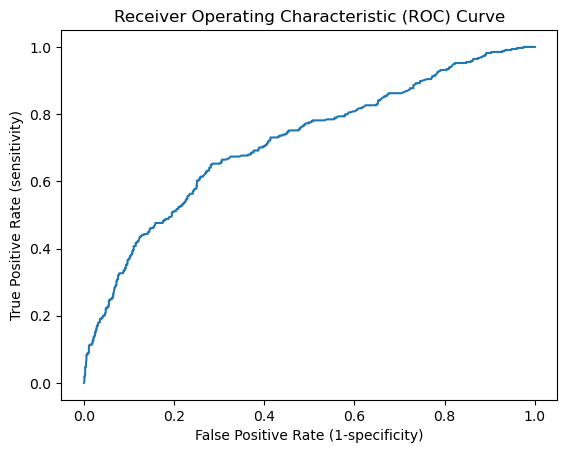

In [24]:
train_gradient_boosting_model(X_train, y_train, X_test, '../submissions/th_gradient_boost.csv', df2, threshold=0.222)

              precision    recall  f1-score   support

           0       0.87      0.65      0.74      1098
           1       0.37      0.69      0.48       334

    accuracy                           0.66      1432
   macro avg       0.62      0.67      0.61      1432
weighted avg       0.76      0.66      0.68      1432

ROC_AUC_SCORE: 0.6676264956425946


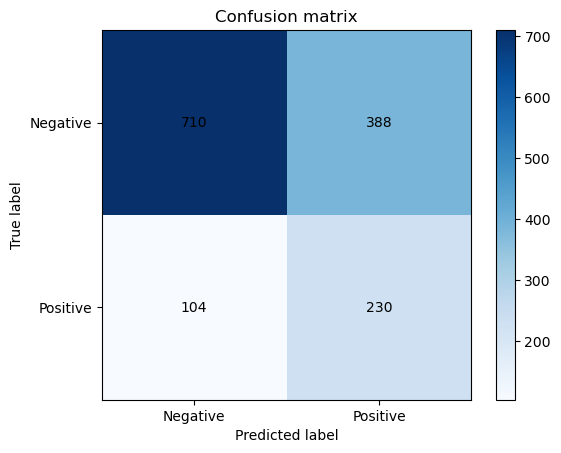

Optimal threshold: 0.18999266646518465


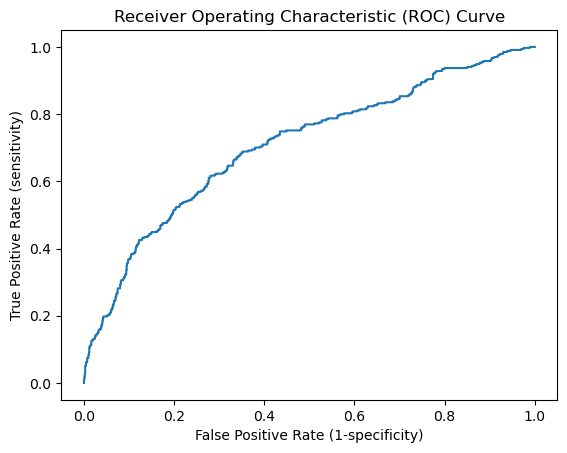

In [26]:
train_stacking_model(X_train, y_train, X_test, '../submissions/th_stacking.csv', df2, threshold=0.189)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best score:  0.867617167605561
              precision    recall  f1-score   support

           0       0.85      0.66      0.74      1098
           1       0.35      0.62      0.45       334

    accuracy                           0.65      1432
   macro avg       0.60      0.64      0.60      1432
weighted avg       0.73      0.65      0.67      1432

ROC_AUC_SCORE: 0.6376182062105298


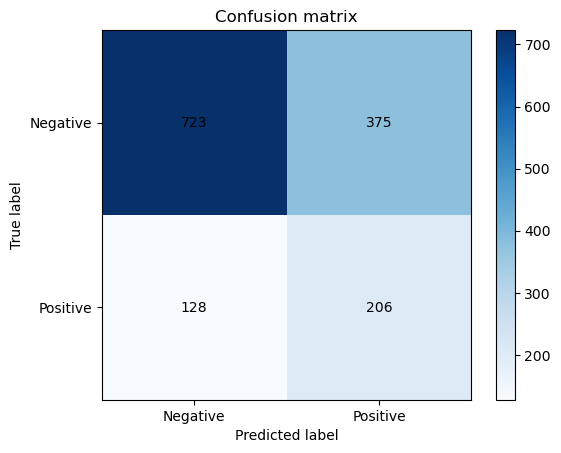

Optimal threshold: 0.32817658730158733


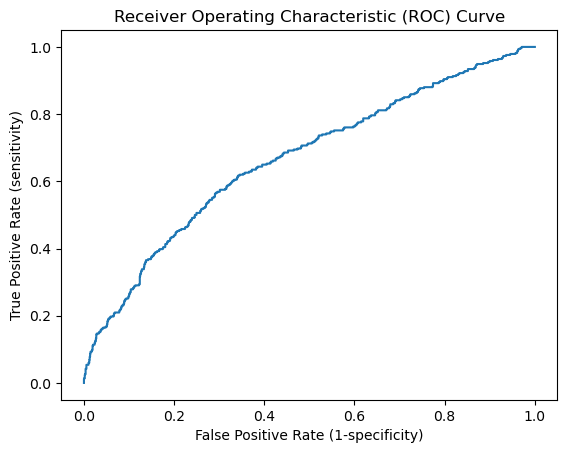

In [27]:
train_random_forest_model(X_train_sm_resampled, y_train_sm_resampled, X_test, '../submissions/th_smote_random_forest.csv', df2, threshold=0.328)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Best score:  0.8819717414516027
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1098
           1       0.40      0.49      0.44       334

    accuracy                           0.71      1432
   macro avg       0.62      0.63      0.62      1432
weighted avg       0.73      0.71      0.72      1432

ROC_AUC_SCORE: 0.6345287566942618


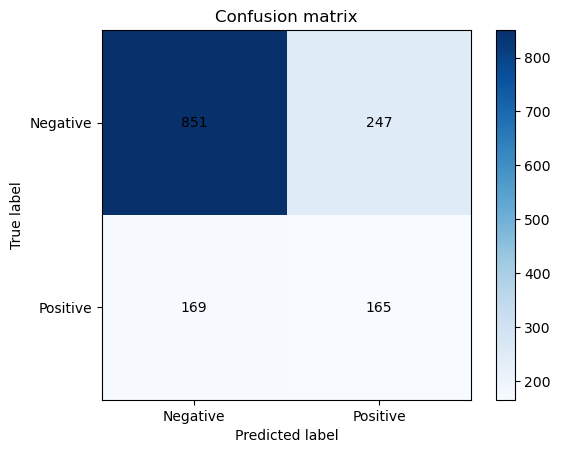

Optimal threshold: 0.39206344


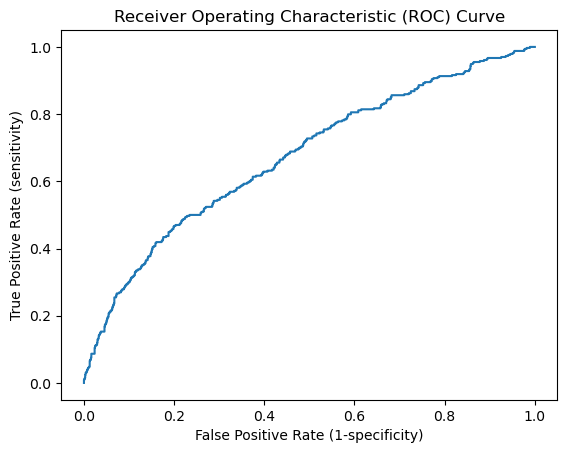

In [28]:
train_xgboost_model(X_train_sm_resampled, y_train_sm_resampled, X_test, '../submissions/th_smote_xgboost.csv', df2, threshold=0.392)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best score:  0.8846362280215153
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1098
           1       0.43      0.43      0.43       334

    accuracy                           0.73      1432
   macro avg       0.63      0.63      0.63      1432
weighted avg       0.73      0.73      0.73      1432

ROC_AUC_SCORE: 0.6275509091107402


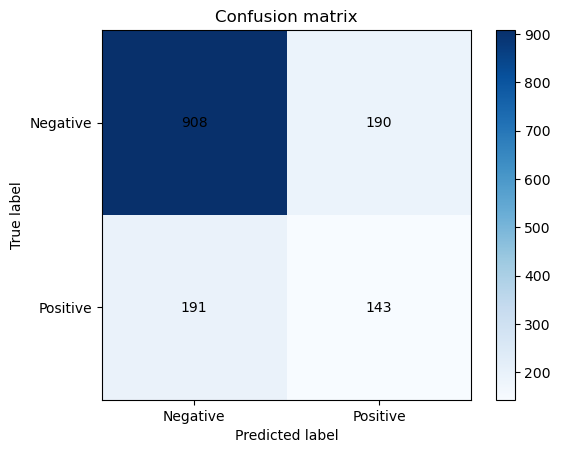

Optimal threshold: 0.4683468615369834


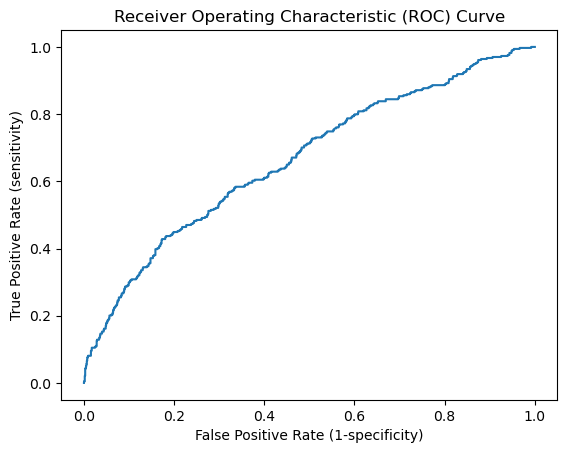

In [29]:
train_gradient_boosting_model(X_train_sm_resampled, y_train_sm_resampled, X_test, '../submissions/th_smote_gradient_boost.csv', df2, threshold=0.468)

### Utilizing TabNet Deep Learning Model

In [ ]:
df.head()

In [ ]:
def train_TabNet(df):
    # Split the data into training and validation sets
    train_data = df.sample(frac=0.8, random_state=42)
    val_data = df.drop(train_data.index)

    # Define the columns to use as input features and target
    cat_cols = ["categorical_feature1", "categorical_feature2"]
    num_cols = ["numerical_feature1", "numerical_feature2"]
    target_col = "Claim"

    # Initialize the TabNet model with default parameters
    tabnet_model = TabNetClassifier(cat_cols=cat_cols, num_cols=num_cols, 
                                    output_dim=2, optimizer_fn=torch.optim.Adam, 
                                    optimizer_params=dict(lr=2e-2), 
                                    scheduler_params={"step_size":10, "gamma":0.9},
                                    scheduler_fn=torch.optim.lr_scheduler.StepLR)

    # Train the model on the training data
    tabnet_model.fit(X_train=train_data.drop(target_col, axis=1).values, y_train=train_data[target_col].values,
                     eval_set=[(val_data.drop(target_col, axis=1).values, val_data[target_col].values)],
                     max_epochs=50, patience=20)

    # Plot the training loss
    if hasattr(tabnet_model, 'history'):
        plt.plot(tabnet_model.history['train']['loss'], label='Train Loss')
        plt.plot(tabnet_model.history['valid']['loss'], label='Valid Loss')
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

    # Use the model to make predictions on new data
    val_preds = tabnet_model.predict(val_data.drop(target_col, axis=1).values)
    
    # Calculate classification metrics
    val_acc = accuracy_score(val_data[target_col], val_preds)
    val_precision = precision_score(val_data[target_col], val_preds)
    val_recall = recall_score(val_data[target_col], val_preds)
    val_f1 = f1_score(val_data[target_col], val_preds)
    val_roc_auc = roc_auc_score(val_data[target_col], tabnet_model.predict_proba(val_data.drop(target_col, axis=1).values)[:, 1])

    # Print the metrics
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1 score: {val_f1:.4f}")
    print(f"Validation AUC-ROC score: {val_roc_auc:.4f}")

    # Generate a confusion matrix heatmap
    conf_mat = confusion_matrix(val_data[target_col].values, val_preds)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [ ]:
# Calculate class weights
class_counts = train_data[target_col].value_counts()
class_weights = {0: 1 / class_counts[0], 1: 1 / class_counts[1]}

# Initialize the TabNet model with class weights
tabnet_model = TabNetClassifier(cat_cols=cat_cols, num_cols=num_cols, 
                                output_dim=2, optimizer_fn=torch.optim.Adam, 
                                optimizer_params=dict(lr=2e-2), 
                                scheduler_params={"step_size":10, "gamma":0.9},
                                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                class_weight=class_weights)

In [ ]:
# Use the model to make predictions on new data
val_probs = tabnet_model.predict_proba(val_data.drop(target_col, axis=1).values)

# Set the decision threshold to 0.7
decision_threshold = 0.7

# Convert the probabilities to binary labels using the decision threshold
val_preds = (val_probs[:, 1] >= decision_threshold).astype(int)


### Multi Layer Perceptron

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from torch.utils.data import DataLoader

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Load the dataframe and split it into training and validation sets
df = pd.read_csv("data.csv")
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Define the grid search parameters
param_grid = {
    'hidden_size': [32, 64, 128],
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64]
}

# Create the data loader
feature_cols = [...]  # Replace with the feature columns
target_col = [...]  # Replace with the target column
train_dataset = MyDataset(train_df, feature_cols, target_col)
train_loader = DataLoader(train_dataset, shuffle=True)

# Calculate class weights
class_counts = train_df[target_col].value_counts()
total_count = class_counts.sum()
class_weights = [total_count / count for count in class_counts]

# Create the model, loss function, and optimizer
model = MLP(len(feature_cols), output_size)
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights))

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(train_loader.dataset[:][0], train_loader.dataset[:][1])

# Print the best parameters
print("Best parameters found:")
print(grid_search.best_params_)

# Train the model with the best hyperparameters
best_params = grid_search.best_params_
model = MLP(len(feature_cols), best_params['hidden_size'], output_size)
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)

num_epochs = 10
train_losses = []
for epoch in range(num_epochs):
    train_loss = 0.0
    for X, y in train_loader:
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

# Save the model weights
torch.save(model.state_dict(), "model_weights.pth")

# Plot the loss curve
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [ ]:
#predict.py
import pandas as pd
import torch
import torch.nn as nn
import argparse

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Load the saved model weights
model = MLP(input_size, hidden_size, output_size)
model.load_state_dict(torch.load('model_weights.pth'))

# Load the new dataset
df = pd.read_csv("new_data.csv")

# Convert the dataset to a tensor
feature_cols = []
X = torch.tensor(df[feature_cols].values, dtype=torch.float)

# Make predictions
with torch.no_grad():
    outputs = model(X)
    _, predicted = torch.max(outputs.data, 1)

# Save the predictions to a CSV file
df['predicted'] = predicted.numpy()
df.to_csv('../submissions/mlp_predictions.csv', index=False)


In [ ]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import joblib

# Load the dataframe and split it into training and validation sets
df = pd.read_csv("data.csv")
X = df.drop(columns=['target']) # Replace 'target' with your target column name
y = df['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the MLP model and hyperparameters to tune
mlp = MLPClassifier()
param_grid = {
    'hidden_layer_sizes': [(32,), (64,), (128,)],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64]
}

# Perform grid search
grid_search = GridSearchCV(mlp, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found:")
print(grid_search.best_params_)

# Evaluate the model with the best hyperparameters
best_params = grid_search.best_params_
mlp = MLPClassifier(hidden_layer_sizes=best_params['hidden_layer_sizes'],
                    learning_rate_init=best_params['learning_rate_init'],
                    batch_size=best_params['batch_size'])
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_val)
print("Validation accuracy:", accuracy_score(y_val, y_pred))

# Save the model
joblib.dump(mlp, "mlp_model.pkl")

# Load the model and make predictions on new data
new_data = pd.read_csv("new_data.csv") # Replace with your new data file
new_X = new_data.drop(columns=['target']) # Replace 'target' with your target column name
loaded_model = joblib.load("mlp_model.pkl")
new_y_pred = loaded_model.predict(new_X)
